In [1]:
%matplotlib inline


# Segmenting the picture of greek coins in regions

This example uses `spectral_clustering` on a graph created from
voxel-to-voxel difference on an image to break this image into multiple
partly-homogeneous regions.

This procedure (spectral clustering on an image) is an efficient
approximate solution for finding normalized graph cuts.

There are two options to assign labels:

* with 'kmeans' spectral clustering will cluster samples in the embedding space
  using a kmeans algorithm
* whereas 'discrete' will iteratively search for the closest partition
  space to the embedding space.


In [2]:
# Author: Gael Varoquaux <gael.varoquaux@normalesup.org>, Brian Cheung
# License: BSD 3 clause

import time

import numpy as np
from scipy.ndimage.filters import gaussian_filter as scipy_gaussian_filter

import matplotlib.pyplot as plt
import skimage
from skimage.data import coins
from skimage.transform import rescale as skimage_rescale

from sklearn.feature_extraction import image

from sklearn.cluster import spectral_clustering
from sklearn.utils.fixes import parse_version

# these were introduced in skimage-0.14
if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

def create_image_graph(coins, gaussian_filter, rescale):
    # Resize it to 20% of the original size to speed up the processing
    # Applying a Gaussian filter for smoothing prior to down-scaling
    # reduces aliasing artifacts.
    smoothened_coins = gaussian_filter(coins, sigma=2)
    # Taking the old array for cucim as we don't need to change cucim to support Array API
    # We'll change skimage to support Array API rather.    
    # smoothened_coins = smoothened_coins._array if hasattr(smoothened_coins, '_array') else smoothened_coins
    rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", **rescale_params)

    # Convert the image into a graph with the value of the gradient on the
    # edges.
    graph = image.img_to_graph(rescaled_coins)
    return rescaled_coins, graph

## With NumPy

In [3]:
import numpy.array_api as npx
rescaled_coins1, graph1 = create_image_graph(npx.asarray(coins()), scipy_gaussian_filter, skimage_rescale)
rescaled_coins1, graph1

/tmp/ipykernel_25876/543867240.py:1: UserWarning: The numpy.array_api submodule is still experimental. See NEP 47.
  import numpy.array_api as npx
/work/aktech/miniconda3/envs/amd-cucim-new/lib/python3.8/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
/work/aktech/miniconda3/envs/amd-cucim-new/lib/python3.8/site-packages/skimage/transform/_warps.py:190: UserWarning: The numpy.array_api submodule is still experimental. See NEP 47.
  import cupy.array_api as cpx


(Array([[0.50959853, 0.52156988, 0.51372549, ...,
         0.38033121, 0.34862428, 0.12501764],
        [0.50999679, 0.50607522, 0.50626182, ...,
         0.36072253, 0.33325318, 0.23390525],
        [0.50228222, 0.49412391, 0.49411765, ...,
         0.34901961, 0.34117021, 0.31695116],
        ...,
        [0.29021946, 0.28987464, 0.29019608, ...,
         0.27071556, 0.29004329, 0.12816942],
        [0.29433598, 0.27850401, 0.28216634, ...,
         0.28280045, 0.28535027, 0.07375546],
        [0.29419362, 0.26282024, 0.27823976, ...,
         0.29816654, 0.2262007 , 0.0351789 ]], dtype=float64),
 <4697x4697 sparse matrix of type '<class 'numpy.float64'>'
 	with 23209 stored elements in COOrdinate format>)

In [4]:
type(rescaled_coins1)

numpy.array_api._array_object.Array

## With CuPy

In [5]:
from cupyx.scipy.ndimage import gaussian_filter as cupy_gaussian_filter
from cucim.skimage.transform import rescale as cucim_rescale
import cupy.array_api as cpx

# rescale_function = cucim_rescale
rescale_function = skimage_rescale

orig_coins = cpx.asarray(coins())
rescaled_coins2, graph2 = create_image_graph(orig_coins, cupy_gaussian_filter, rescale_function)
rescaled_coins2, graph2

(Array([[0.50959853, 0.52156988, 0.51372549, ...,
         0.38033121, 0.34862428, 0.12501764],
        [0.50999679, 0.50607522, 0.50626182, ...,
         0.36072253, 0.33325318, 0.23390525],
        [0.50228222, 0.49412391, 0.49411765, ...,
         0.34901961, 0.34117021, 0.31695116],
        ...,
        [0.29021946, 0.28987464, 0.29019608, ...,
         0.27071556, 0.29004329, 0.12816942],
        [0.29433598, 0.27850401, 0.28216634, ...,
         0.28280045, 0.28535027, 0.07375546],
        [0.29419362, 0.26282024, 0.27823976, ...,
         0.29816654, 0.2262007 , 0.0351789 ]], dtype=float64),
 <4697x4697 sparse matrix of type '<class 'numpy.float64'>'
 	with 23209 stored elements in COOrdinate format>)

#### This should return new Array when implementation is complete

In [6]:
type(rescaled_coins2)

cupy.array_api._array_object.Array

## Plots: WIP

In [7]:
# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 10
eps = 1e-6

def set_graph_data(array, graph):
    graph.data = array.exp(-beta * array.asarray(graph.data) / array.std(array.asarray(graph.data))) + eps
    graph.data = graph.data._array
    return graph

graph1 = set_graph_data(npx, graph1)
graph2 = set_graph_data(cpx, graph2)
# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 25

Visualize the resulting regions



In [8]:
def plot_(graph, rescaled_coins):
    for assign_labels in ("kmeans", "discretize"):
        t0 = time.time()
        labels = spectral_clustering(
            graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=42
        )
        t1 = time.time()
        labels = labels.reshape(rescaled_coins.shape)

        plt.figure(figsize=(5, 5))
        plt.imshow(rescaled_coins, cmap=plt.cm.gray)
        for l in range(N_REGIONS):
            plt.contour(labels == l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
        plt.xticks(())
        plt.yticks(())
        title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
        print(title)
        plt.title(title)
    plt.show()

Spectral clustering: kmeans, 4.17s
Spectral clustering: discretize, 3.54s


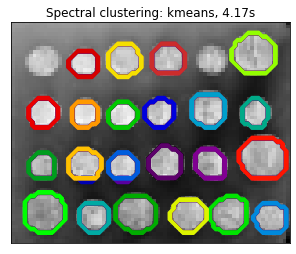

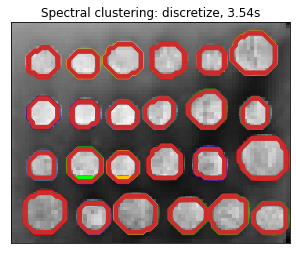

In [9]:
plot_(graph1, rescaled_coins1)

In [15]:
graph2.data = graph2.data.get()

Spectral clustering: kmeans, 4.52s
Spectral clustering: discretize, 3.70s


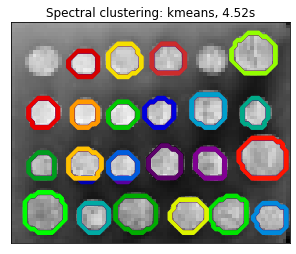

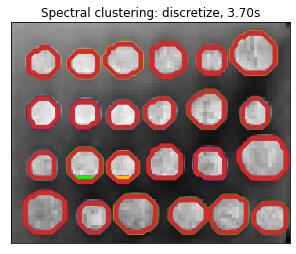

In [16]:
plot_(graph2, rescaled_coins2._array.get())